<h1 align=left><font size = 4>Peer-graded Assignment:</font></h1>
<h2 align=center><font size = 5>Segmenting and Clustering Neighbourhoods in Toronto</font></h2>

# Part 1

## Scrape Wikipedia to obtain table of Toronto Postal Codes, Boroughs and Neighbourhoods

We will use the Wikepedia webpage https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M in order to obtain the data that is in the table of postal codes and to transform the data into a pandas  dataframe that will look like this:

|| Postal Code | Borough | Neigbourhood |
|---| --- | --- | --- |
|0| M5G | Downtown Toronto | Central Bay Street |
|1| M2H | North York | Hillcrest Village |
|2| M4B | East York | Parkview Hill, Woodbine Gardens |
|...| ... | ... | ... |

Before we start working we need to import the necesarry libraries

In [218]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [219]:
#!pip3 install lxml

In [220]:
#import additional libraries
import lxml


## 1 Scrape Wikepedia page

In [221]:
#input
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

html_df = pd.read_html(url)

In [222]:
print('The object that was read was of type {} containing {} elements: \n'.format(type(html_df),len(html_df)))

for i in range(len(html_df)):
    print('   Element no. {} is of type {} itself of dimension {}'.format(i,type(html_df[i]),html_df[i].shape))
    
print('\n Inspection shows that the information we need is located in the first element.')

Toronto_df = html_df[0]
Toronto_df.head()

The object that was read was of type <class 'list'> containing 3 elements: 

   Element no. 0 is of type <class 'pandas.core.frame.DataFrame'> itself of dimension (180, 3)
   Element no. 1 is of type <class 'pandas.core.frame.DataFrame'> itself of dimension (4, 18)
   Element no. 2 is of type <class 'pandas.core.frame.DataFrame'> itself of dimension (2, 18)

 Inspection shows that the information we need is located in the first element.


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## 2 Drop rows where Borough is Not assigned

In [223]:
# check unique values of Borough and notice it contains "Not assigned"
Toronto_df['Borough'].unique()

array(['Not assigned', 'North York', 'Downtown Toronto', 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [224]:
len(Toronto_df['Borough'].unique())

11

We will ignore the cells where a borough is not assigned. This means we can drop the rows where the Borough is "Not assigned".

In [225]:
Toronto_df = Toronto_df[Toronto_df['Borough']!='Not assigned']

In [226]:
Toronto_df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [227]:
print('Now dimentions of Toronto_df is {} without the unassinged boroughs {}: \n'
      . format(Toronto_df.shape, len(Toronto_df['Borough'].unique())))
print(Toronto_df['Borough'].unique().tolist())

Now dimentions of Toronto_df is (103, 3) without the unassinged boroughs 10: 

['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto', 'Central Toronto', 'Mississauga']


In [228]:
Toronto_df.reset_index(drop=True,inplace=True)
Toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## 3 For Neighbourhoods Not assigned, make Neighbourhoods same as Borough

In [229]:
#replace any neigbourhoods which are not assined by the borough
Toronto_df.loc[Toronto_df['Neighbourhood']=='Not assigned','Neighbourhood']=Toronto_df['Borough']

c:\users\mabra\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\mabra\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [230]:
(Toronto_df['Neighbourhood']=='Not assigned').unique()

array([False])

In [231]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## 4 Aggregate Neighbourhoods by Postal Code

In [232]:
Toronto_df = Toronto_df.groupby(['Postal Code','Borough'], as_index=False).agg(lambda x: ", ".join(x))

In [233]:
#each postal code contains one neighbourhood or a list of neighbourhoods separated by a comma
Toronto_df.groupby('Postal Code').count()['Neighbourhood'].unique() 

array([1], dtype=int64)

## 5 Preview data and display shape/dimansions

In [234]:
#Toronto_df.reset_index(inplace=True)
Toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [235]:
print('The final dimension of the Toronto_df after transforming and cleaning the data is {}.'.format(Toronto_df.shape))

The final dimension of the Toronto_df after transforming and cleaning the data is (103, 3).


# Part 2

In [236]:
coord = pd.read_csv('Geospatial_Coordinates.csv')

In [237]:
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [238]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [239]:
Toronto_df = Toronto_df.merge(coord, how='left', on = 'Postal Code')

In [240]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [241]:
print('The final shape/dimensions of the Toronto_df after addint latitude and longitude is {}.\n'.format(Toronto_df.shape))
print('The columns are:\n')
for col in Toronto_df.columns:
    print('    ', col) 

The final shape/dimensions of the Toronto_df after addint latitude and longitude is (103, 5).

The columns are:

     Postal Code
     Borough
     Neighbourhood
     Latitude
     Longitude


In [242]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Part 3

#### Use geopy library to get the latitude and longitude values of Toronto.

In [243]:
#In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent Toronto_explorer, as shown below.

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate ofToronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate ofToronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [244]:
# create map of New York using latitude and longitude values
#made a small adjustment to the latitude of the city so as to be able to zoom more and see all neighbourhoods clearly

map_toronto = folium.Map(location=[latitude+.07, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [245]:
Toronto_df = Toronto_df[Toronto_df['Borough'].str.contains("Toronto")]
Toronto_df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


#### Define Foursquare Credentials and Version

In [246]:
CLIENT_ID = 'KKG4SRJ4GUTENEN5JO0GZZYO1B1VGEXJOB4IQKLIH2013RO5' # your Foursquare ID
CLIENT_SECRET = 'yQDKK4IFZSNZ0OQFSTVRGSAIMITKPEXS4BDACYP2IO5DFPW0J' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
ACCESS_TOKEN = 'H3EMBYC33OFIKUMYQDUDJEWDXPMV2U0QHSU0APOVCR2TV52K' # your FourSquare Access Token
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KKG4SRJ4GUTENEN5JO0GZZYO1B1VGEXJOB4IQKLIH2013RO5
CLIENT_SECRET:yQDKK4IFZSNZ0OQFSTVRGSAIMITKPEXS4BDACYP2IO5DFPW0J


#### Now, let's get the top 100 venues that are within a radius of 500 meters in each Boroigh

In [247]:
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url= 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng,
            ACCESS_TOKEN,
            VERSION, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [248]:
Toronto_venues = getNearbyVenues(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [249]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


### Analyze Each Neighborhood

In [250]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# insert neighborhood column back to dataframe in the first column
Toronto_onehot.insert(0,'Neighbourhood', Toronto_venues['Neighbourhood']) 

Toronto_onehot.head()

,Neighbourhood,ATM,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,

In [251]:
#And let's examine the new dataframe size.
Toronto_onehot.shape

(2167, 273)

#### Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [252]:
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

,Neighbourhood,ATM,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Berczy Park,0.000000,0

In [253]:
#And let's examine the new dataframe size.
Toronto_grouped.shape

(39, 273)

In [254]:
#Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.12
1        Cocktail Bar  0.04
2      Sandwich Place  0.04
3              Bakery  0.04
4  Italian Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.11
1  Sandwich Place  0.07
2       Nightclub  0.07
3            Park  0.07
4  Breakfast Spot  0.07


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Fast Food Restaurant  0.09
1  Gym / Fitness Center  0.09
2    Light Rail Station  0.09
3           Yoga Studio  0.04
4         Auto Workshop  0.04


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.16
1  Rental Car Location  0.11
2       Airport Lounge  0.11
3     Airport Terminal  0.11
4        Boat or Ferry  0.05


----Central Bay Street----
              venu

In [255]:
#First, let's write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [256]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Sandwich Place,Bakery,Italian Restaurant,Pub,Hotel,Restaurant,Cheese Shop,French Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Sandwich Place,Nightclub,Park,Breakfast Spot,Coffee Shop,Japanese Restaurant,Stadium,Climbing Gym,Bar
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Gym / Fitness Center,Light Rail Station,Yoga Studio,Auto Workshop,Brewery,Skate Park,Butcher,Spa,Farmers Market
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Rental Car Location,Airport Lounge,Airport Terminal,Boat or Ferry,Airport,Airport Food Court,Airport Gate,Bar,Coffee Shop
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Chinese Restaurant,Bank


## Cluster Neighbourhoods

To determine the appropriate number of clusters we will run the clustering for a range of values of k clusters from 1 to 15. In every iteration we will note down teh sum of squared distances and the plot them to see what is the optimum



In [257]:
Sum_of_squared_distances = []

Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

for kclusters in range(1,15):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    

kmeans.labels_ 

array([ 9,  1,  5,  0,  9, 11,  9, 12,  9, 10, 13, 12,  6,  9,  9, 13,  5,
        9,  8,  9,  4,  1,  9,  9,  1, 12,  2,  3,  9,  9,  1,  9,  1,  9,
        1,  7,  1, 12,  1])

We will use number of clusters k = 5


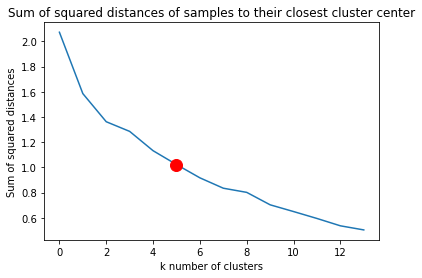

In [258]:
import matplotlib.pyplot as plt
plt.plot(Sum_of_squared_distances)
plt.xlabel('k number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Sum of squared distances of samples to their closest cluster center')

plt.plot( [5.0],[Sum_of_squared_distances[5]], marker='o', markersize=12, color = 'red')
print('We will use number of clusters k = 5')

In [259]:
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 3, 0, 3, 3, 3, 1, 3,
       0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [260]:
Neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Sandwich Place,Bakery,Italian Restaurant,Pub,Hotel,Restaurant,Cheese Shop,French Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Sandwich Place,Nightclub,Park,Breakfast Spot,Coffee Shop,Japanese Restaurant,Stadium,Climbing Gym,Bar
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Gym / Fitness Center,Light Rail Station,Yoga Studio,Auto Workshop,Brewery,Skate Park,Butcher,Spa,Farmers Market
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Rental Car Location,Airport Lounge,Airport Terminal,Boat or Ferry,Airport,Airport Food Court,Airport Gate,Bar,Coffee Shop
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Chinese Restaurant,Bank


In [261]:
#Neighbourhoods_venues_sorted.drop('Cluster Labels',axis=1, inplace = True)

In [262]:
# add clustering labels  DataFrame.insert(loc, column, value, allow_duplicates=False)
Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [263]:
Neighbourhoods_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Berczy Park,Coffee Shop,Cocktail Bar,Sandwich Place,Bakery,Italian Restaurant,Pub,Hotel,Restaurant,Cheese Shop,French Restaurant
1,0,"Brockton, Parkdale Village, Exhibition Place",Café,Sandwich Place,Nightclub,Park,Breakfast Spot,Coffee Shop,Japanese Restaurant,Stadium,Climbing Gym,Bar
2,3,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Gym / Fitness Center,Light Rail Station,Yoga Studio,Auto Workshop,Brewery,Skate Park,Butcher,Spa,Farmers Market
3,3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Rental Car Location,Airport Lounge,Airport Terminal,Boat or Ferry,Airport,Airport Food Court,Airport Gate,Bar,Coffee Shop
4,0,Central Bay Street,Coffee Shop,Café,Sandwich Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Chinese Restaurant,Bank


In [264]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [265]:
Toronto_merged = Toronto_df.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')


In [266]:
Toronto_merged.head() 

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pizza Place,Park,Asian Restaurant,Pub,Coffee Shop,Trail,Neighborhood,Home Service,Health Food Store,Modern European Restaurant
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Bookstore,Restaurant,Paper / Office Supplies Store,Pizza Place,Frozen Yogurt Shop
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Fast Food Restaurant,Pizza Place,Sandwich Place,Park,Mobile Phone Shop,Fish & Chips Shop,Brewery,Motorcycle Shop,Food & Drink Shop,Coffee Shop
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Gym,Yoga Studio,Coffee Shop,American Restaurant,Café,Bakery,Music Store,Gastropub,Brewery,Martial Arts School
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Photography Studio,Business Service,Construction & Landscaping,Swim School,Lawyer,Park,Gym / Fitness Center,Bus Line,Museum,Moving Target


Finally, let's visualize the resulting clusters

In [267]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [268]:
from IPython.display import display

In [269]:
#display all clusters and their most common venues
for k in range(0,kclusters):
    print('\n Cluster {} most common venues:\n'.format(k))
    display(Toronto_merged.loc[Toronto_merged['Cluster Labels'] == k, 
                               Toronto_merged.columns[[1,2] + list(range(5, Toronto_merged.shape[1]))]])


 Cluster 0 most common venues:



,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,The Beaches,0,Pizza Place,Park,Asian Restaurant,Pub,Coffee Shop,Trail,Neighborhood,Home Service,Health Food Store,Modern European Restaurant
41,East Toronto,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Bookstore,Restaurant,Paper / Office Supplies Store,Pizza Place,Frozen Yogurt Shop
42,East Toronto,"India Bazaar, The Beaches West",0,Fast Food Restaurant,Pizza Place,Sandwich Place,Park,Mobile Phone Shop,Fish & Chips Shop,Brewery,Motorcycle Shop,Food & Drink Shop,Coffee Shop
43,East Toronto,Studio District,0,Gym,Yoga Studio,Coffee Shop,American Restaurant,Café,Bakery,Music Store,Gastropub,Brewery,Martial Arts School
45,Central Toronto,Davisville North,0,Hotel,Convenience Store,Gym / Fitness Center,Dog Run,Breakfast Spot,Sandwich Place,Department Store,Food & Drink Shop,Gym,Supplement Shop
47,Central Toronto,Davisville,0,Pizza Place,Dessert Shop,Café,Sandwich Place,Coffee Shop,Italian Restaurant,Sushi Restaurant,Gym,Brewery,Farmers Market
49,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0,Light Rail Station,Coffee Shop,Bagel Shop,Pub,Sushi Restaurant,Restaurant,Supermarket,Liquor Store,Sandwich Place,Fried Chicken Joint
51,Downtown Toronto,"St. James Town, Cabbagetown",0,Coffee Shop,Café,Pharmacy,Pet Store,Park,Bakery,Pub,Liquor Store,Pizza Place,Gourmet Shop
52,Downtown Toronto,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Burrito Place,Burger Joint,Yoga Studio,Gym,Mediterranean Restaurant,Chinese Restaurant
53,Downtown Toronto,"Regent Park, Harbourfront",0,Coffee Shop,Pub,Bakery,Furniture / Home Store,Park,Café,Theater,Beer Store,Sandwich Place,Breakfast Spot



 Cluster 1 most common venues:



,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,"Moore Park, Summerhill East",1,Playground,Tennis Court,Park,Beer Store,Trail,ATM,Moroccan Restaurant,Music Store,Museum,Moving Target
50,Downtown Toronto,Rosedale,1,Park,Trail,Playground,Monument / Landmark,Music Store,Museum,Moving Target,Movie Theater,Motorcycle Shop,Moroccan Restaurant



 Cluster 2 most common venues:



,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",2,Trail,Park,Sushi Restaurant,Jewelry Store,Bus Line,Moroccan Restaurant,Music Store,Museum,Moving Target,Movie Theater



 Cluster 3 most common venues:



,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,Lawrence Park,3,Photography Studio,Business Service,Construction & Landscaping,Swim School,Lawyer,Park,Gym / Fitness Center,Bus Line,Museum,Moving Target
46,Central Toronto,"North Toronto West, Lawrence Park",3,Clothing Store,Sporting Goods Shop,Cosmetics Shop,Spa,Coffee Shop,Salon / Barbershop,Yoga Studio,Shoe Store,Men's Store,Metro Station
67,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",3,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Mexican Restaurant,Bar,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Thai Restaurant
68,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",3,Airport Service,Rental Car Location,Airport Lounge,Airport Terminal,Boat or Ferry,Airport,Airport Food Court,Airport Gate,Bar,Coffee Shop
76,West Toronto,"Dufferin, Dovercourt Village",3,Pharmacy,Bakery,Pool,Athletics & Sports,Brewery,Middle Eastern Restaurant,Pizza Place,Café,Furniture / Home Store,Supermarket
77,West Toronto,"Little Portugal, Trinity",3,Bar,Coffee Shop,Men's Store,Boutique,Bank,Restaurant,Yoga Studio,Asian Restaurant,Mexican Restaurant,Café
82,West Toronto,"High Park, The Junction South",3,Bakery,Mexican Restaurant,Thai Restaurant,Café,Park,Discount Store,Nightlife Spot,Music Venue,Fast Food Restaurant,Flea Market
87,East Toronto,"Business reply mail Processing Centre, South C...",3,Fast Food Restaurant,Gym / Fitness Center,Light Rail Station,Yoga Studio,Auto Workshop,Brewery,Skate Park,Butcher,Spa,Farmers Market



 Cluster 4 most common venues:



,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,Roselawn,4,Home Service,Pool,Ice Cream Shop,Fast Food Restaurant,Health & Beauty Service,Persian Restaurant,Neighborhood,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop


In [270]:
print('Number of neighbourhoods in each cluster: \n', Toronto_merged['Cluster Labels'].value_counts()[1:])

Number of neighbourhoods in each cluster: 
 3    8
1    2
2    1
4    1
Name: Cluster Labels, dtype: int64


So there 5 clusers: 

 - The 1st cluster (k=0) is the largest and contains a high concentration of cafe/coffee shops, restaurants/food place
 - The 2nd cluster (k=1) is the second largest with two neighbourhoods and has lots of outdoor spaces/sports
 - The 3rd cluster (k=2) is just one neighbourhood with different venues
 - The 4th cluster (k=3) is just one neighbourhood with mostly non-food businesses
 - THe 5th cluster (k=4) contains several neighbourhoods all sharing the same initial postcode and has a good mix of outdoor spaces and restaurants